In [372]:
import numpy as np
import pandas as pd
import re
import dateutil.parser
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import feature_selection as f_select
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from collections import Counter
import copy
from sklearn.cross_validation import cross_val_score
sns.set_style("darkgrid")
% matplotlib inline

## Read raw data

In [16]:
raw_movies = pd.read_pickle('raw_movies2.pkl')

In [3]:
raw_movies.head()

,budget,country,country_gross,days_out,distributor,domestic_gross,foreign_gross,genre,num_theaters,opening_weekend,rating,release_date,run_time,title
0,N/A,Argentina,"$16,004,539",175 days / 25 weeks,Buena Vista,"$486,295,561","$542,275,328",Animation,"4,305 theaters","$135,060,273",PG,"June 17, 2016",1 hrs. 43 min.,Finding Dory
1,N/A,Australia,"$36,312,640",175 days / 25 weeks,Buena Vista,"$486,295,561","$542,275,328",Animation,"4,305 theaters","$135,060,273",PG,"June 17, 2016",1 hrs. 43 min.,Finding Dory
2,N/A,Austria,"$4,572,667",175 days / 25 weeks,Buena Vista,"$486,295,561","$542,275,328",Animation,"4,305 theaters","$135,060,273",PG,"June 17, 2016",1 hrs. 43 min.,Finding Dory
3,N/A,Belgium,"$5,204,300",175 days / 25 weeks,Buena Vista,"$486,295,561","$542,275,328",Animation,"4,305 theaters","$135,060,273",PG,"June 17, 2016",1 hrs. 43 min.,Finding Dory
4,N/A,Bolivia,"$1,313,486",175 days / 25 weeks,Buena Vista,"$486,295,561","$542,275,328",Animation,"4,305 theaters","$135,060,273",PG,"June 17, 2016",1 hrs. 43 min.,Finding Dory


## Clean data

### Helper functions

In [4]:
def budget_to_int(budgetstring):
    budgetstring = budgetstring.replace('$', '').replace(',', '')
    if re.sub(r"\D", "", budgetstring) == '':
        return np.nan
    try:
        int(budgetstring)
        return int(budgetstring)
    except:
        budgetstring = budgetstring.split()
        num = float(budgetstring[0])
        if budgetstring[1] == 'million':
            return num*1000000
        else:
            return np.nan

In [5]:
def money_to_int(moneystring):
    if type(moneystring) == int or type(moneystring) == float:
        return moneystring
    elif re.search("[a-zA-Z]", moneystring):
        return np.nan
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

In [6]:
def opening_int(moneystring):
    moneystring = re.sub(r"\D", "", str(moneystring))
    try:
        return int(moneystring)
    except ValueError:
        return np.nan

In [7]:
def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

In [8]:
def widest_release(theatersstring):
    theatersstring = re.sub(r"\D", "", theatersstring)
    return int(theatersstring)

In [9]:
def release_days(releasestring):
    releasestring = str(releasestring)
    releasestring = releasestring.replace('\xa0','')
    releasestring = releasestring.split()
    try:
        return int(releasestring[0])
    except:
        return np.nan

In [10]:
def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

In [11]:
def clean_genre(genre):
    if re.search("Family", genre) or re.search("Animation", genre):
        genre = "Family"
    elif re.search("Foreign", genre):
        genre = "Foreign"
    elif re.search("Comedy", genre):
        genre = "Comedy"
    elif re.search("Drama", genre) or re.search("Romance", genre) or re.search("Crime", genre) or re.search("War", genre) or re.search("Western", genre):
        genre = "Drama"
    elif re.search("Action", genre) or re.search("Adventure", genre) or re.search("Sci-Fi", genre) or re.search("Fantasy", genre):
        genre = "Action-Adventure"
    elif re.search("Thriller", genre):
        genre = "Thriller"
    elif re.search("Horror", genre):
        genre = "Horror"
    elif re.search("Documentary", genre):
        genre = "Documentary"
    else:
        genre = "Other"
    return genre

In [12]:
def clean_dist(distributor):
    if re.search("Universal", distributor) or re.search("Focus Features", distributor):
        distributor = "Universal"
    elif re.search("Fox", distributor):
        distributor = "Fox"
    elif re.search("Warner Bros", distributor):
        distributor = "Warner Bros"
    elif re.search("Buena Vista", distributor) or re.search("Disney", distributor):
        distributor = "Disney"
    elif re.search("Paramount", distributor):
        distributor = "Paramount"
    elif re.search("Lionsgate", distributor) or re.search("Roadside", distributor):
        distributor = "Lionsgate"
    elif re.search("Sony", distributor) or re.search("TriStar", distributor):
        distributor = "Sony"
    elif re.search("Weinstein", distributor):
        distributor = "Weinstein"
    else:
        distributor = 'Independent'
    return distributor

In [13]:
def clean_all_columns(df):
    if df.budget.dtype != 'float64' or df.budget.dtype != 'int64':
        df['budget'] = df.budget.apply(budget_to_int)
    if df.domestic_gross.dtype != 'float64' or df.budget.dtype != 'int64':
        df['domestic_gross'] = df.domestic_gross.apply(money_to_int)
    if df.foreign_gross.dtype != 'float64' or df.budget.dtype != 'int64':
        df['foreign_gross'] = df.foreign_gross.apply(money_to_int)
    if df.country_gross.dtype != 'float64' or df.country_gross.dtype != 'int64':
        df['country_gross'] = df.country_gross.apply(money_to_int)
    if df.opening_weekend.dtype != 'float64' or df.opening_weekend.dtype != 'int64':
        df['opening_weekend'] = df.opening_weekend.apply(opening_int)
    df['run_time'] = df.run_time.apply(runtime_to_minutes)
    df['num_theaters'] = df.num_theaters.apply(widest_release)
    df['days_out'] = df.days_out.apply(release_days)
    df['release_date'] = df.release_date.apply(to_date)
    df['genre'] = df.genre.apply(clean_genre)
    df['distributor'] = df.distributor.apply(clean_dist)
    return df

### Run cleaning functions on dataframe

In [14]:
cleaned_df = clean_all_columns(raw_movies)

In [15]:
cleaned_df.head(2)

,budget,country,country_gross,days_out,distributor,domestic_gross,foreign_gross,genre,num_theaters,opening_weekend,rating,release_date,run_time,title
0,NaN,Argentina,16004539.0,175.0,Disney,486295561,542275328.0,Family,4305,135060273.0,PG,2016-06-17,103.0,Finding Dory
1,NaN,Australia,36312640.0,175.0,Disney,486295561,542275328.0,Family,4305,135060273.0,PG,2016-06-17,103.0,Finding Dory


### Drop NaNs and Foreign Movies

In [17]:
df = cleaned_df.dropna()
df.shape

(28144, 14)

In [18]:
df.genre.value_counts()

Action-Adventure    8819
Comedy              6104
Drama               5682
Family              3276
Thriller            1816
Horror              1787
Other                457
Documentary          103
Foreign              100
Name: genre, dtype: int64

In [19]:
df = df[df['genre'] != 'Foreign']
df.genre.value_counts()

Action-Adventure    8819
Comedy              6104
Drama               5682
Family              3276
Thriller            1816
Horror              1787
Other                457
Documentary          103
Name: genre, dtype: int64

In [20]:
df.shape

(28044, 14)

In [21]:
df = df.reset_index()

In [22]:
df.head(1)

,index,budget,country,country_gross,days_out,distributor,domestic_gross,foreign_gross,genre,num_theaters,opening_weekend,rating,release_date,run_time,title
0,50,20000000.0,Austria,79788.0,42.0,Independent,14326864,17877166.0,Action-Adventure,2335,6231836.0,PG-13,2012-04-13,110.0,Lockout


In [23]:
df = df.drop(['index'], axis = 1)

In [24]:
df.head(1)

,budget,country,country_gross,days_out,distributor,domestic_gross,foreign_gross,genre,num_theaters,opening_weekend,rating,release_date,run_time,title
0,20000000.0,Austria,79788.0,42.0,Independent,14326864,17877166.0,Action-Adventure,2335,6231836.0,PG-13,2012-04-13,110.0,Lockout


In [25]:
df.shape

(28044, 14)

In [26]:
df['month'] = pd.to_datetime(df['release_date'])

In [27]:
df.month = df.month.dt.strftime("%B")

In [28]:
df.head(1)

,budget,country,country_gross,days_out,distributor,domestic_gross,foreign_gross,genre,num_theaters,opening_weekend,rating,release_date,run_time,title,month
0,20000000.0,Austria,79788.0,42.0,Independent,14326864,17877166.0,Action-Adventure,2335,6231836.0,PG-13,2012-04-13,110.0,Lockout,April


In [29]:
df.to_pickle('cleaned_movies_w_country.pkl')

## Examine Data

In [30]:
df = pd.read_pickle('cleaned_movies_w_country.pkl')

In [31]:
no_countries = df.groupby(by=['title', 'distributor', 'genre', 'rating', 'month'], as_index=False)[[
                                                                           'budget', 'days_out', 
                                                                           'domestic_gross', 'foreign_gross', 
                                                                           'num_theaters', 'run_time', 
                                                                           'opening_weekend']].mean()

In [32]:
no_countries.head(5)

,title,distributor,genre,rating,month,budget,days_out,domestic_gross,foreign_gross,num_theaters,run_time,opening_weekend
0,12 Years a Slave,Fox,Drama,R,October,20000000.0,203.0,56671993,131061209.0,1474,133.0,6675731.0
1,127 Hours,Fox,Drama,R,November,18000000.0,161.0,18335230,42403567.0,916,93.0,2136801.0
2,13 Hours: The Secret Soldiers of Benghazi,Paramount,Drama,R,January,50000000.0,70.0,52853219,16558151.0,2917,144.0,16194738.0
3,2 Guns,Universal,Comedy,R,August,61000000.0,84.0,75612460,56327951.0,3028,109.0,27059130.0
4,21 Jump Street,Sony,Comedy,R,March,42000000.0,108.0,138447667,63137661.0,3148,109.0,36302612.0


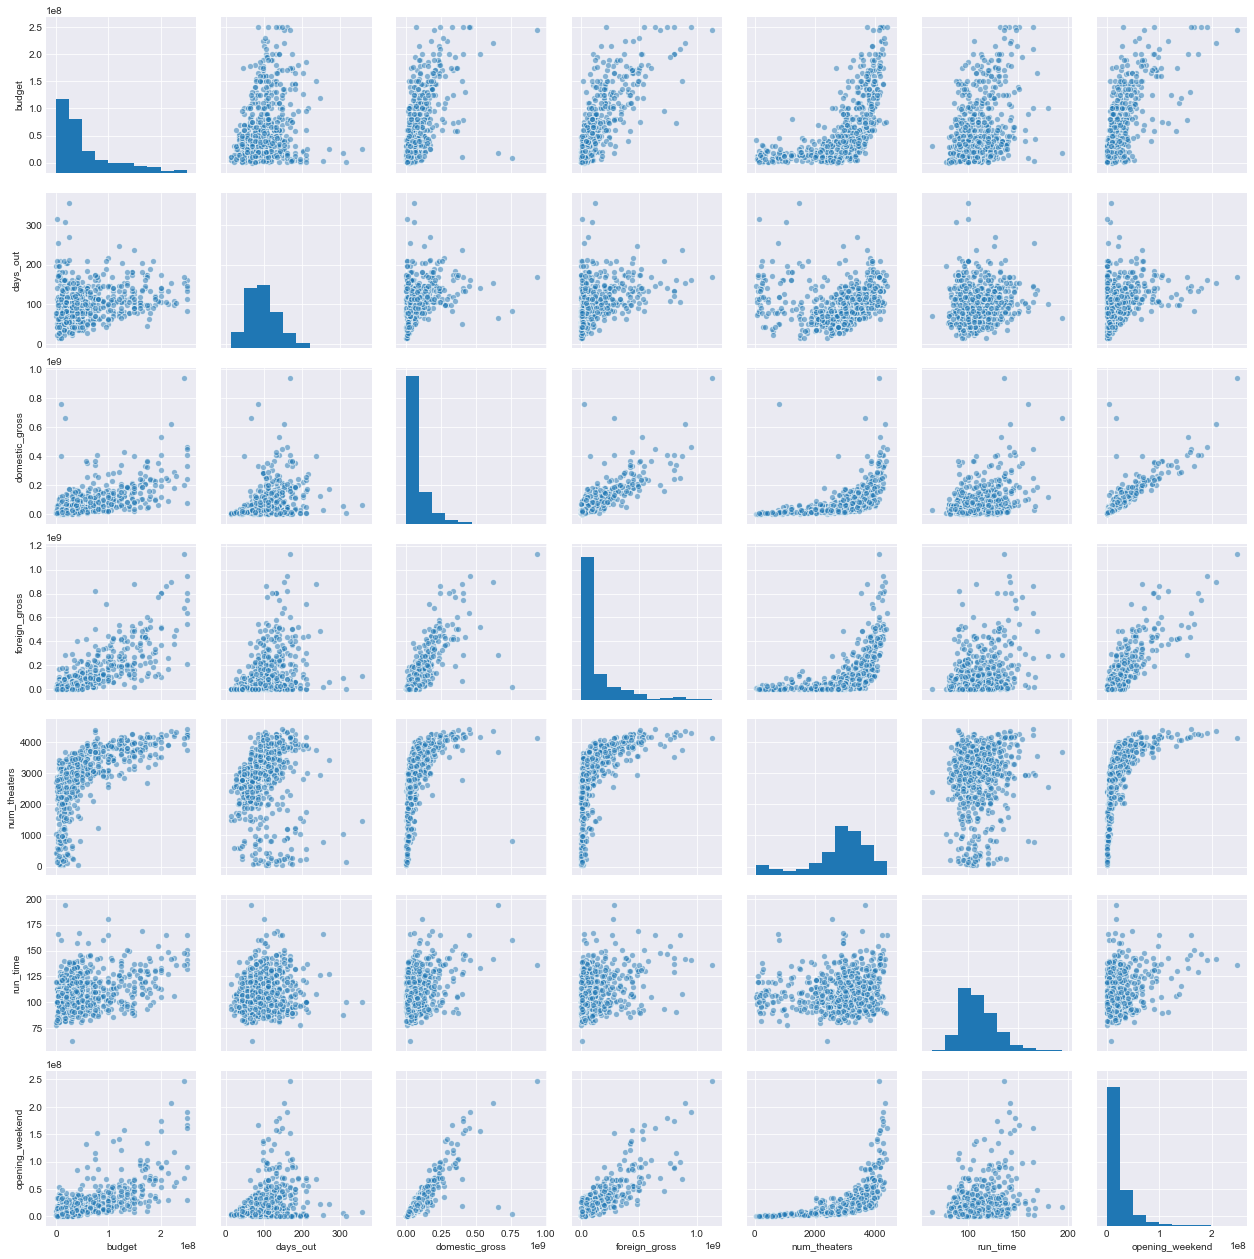

In [33]:
sns.pairplot(no_countries, plot_kws={'alpha':0.5});

In [34]:
no_countries_log = copy.deepcopy(no_countries)
no_countries_log["foreign_gross"] = no_countries_log["foreign_gross"].apply(np.log)
no_countries_log["domestic_gross"] = no_countries_log["domestic_gross"].apply(np.log)
no_countries_log["opening_weekend"] = no_countries_log["opening_weekend"].apply(np.log)
no_countries_log["budget"] = no_countries_log["budget"].apply(np.log)

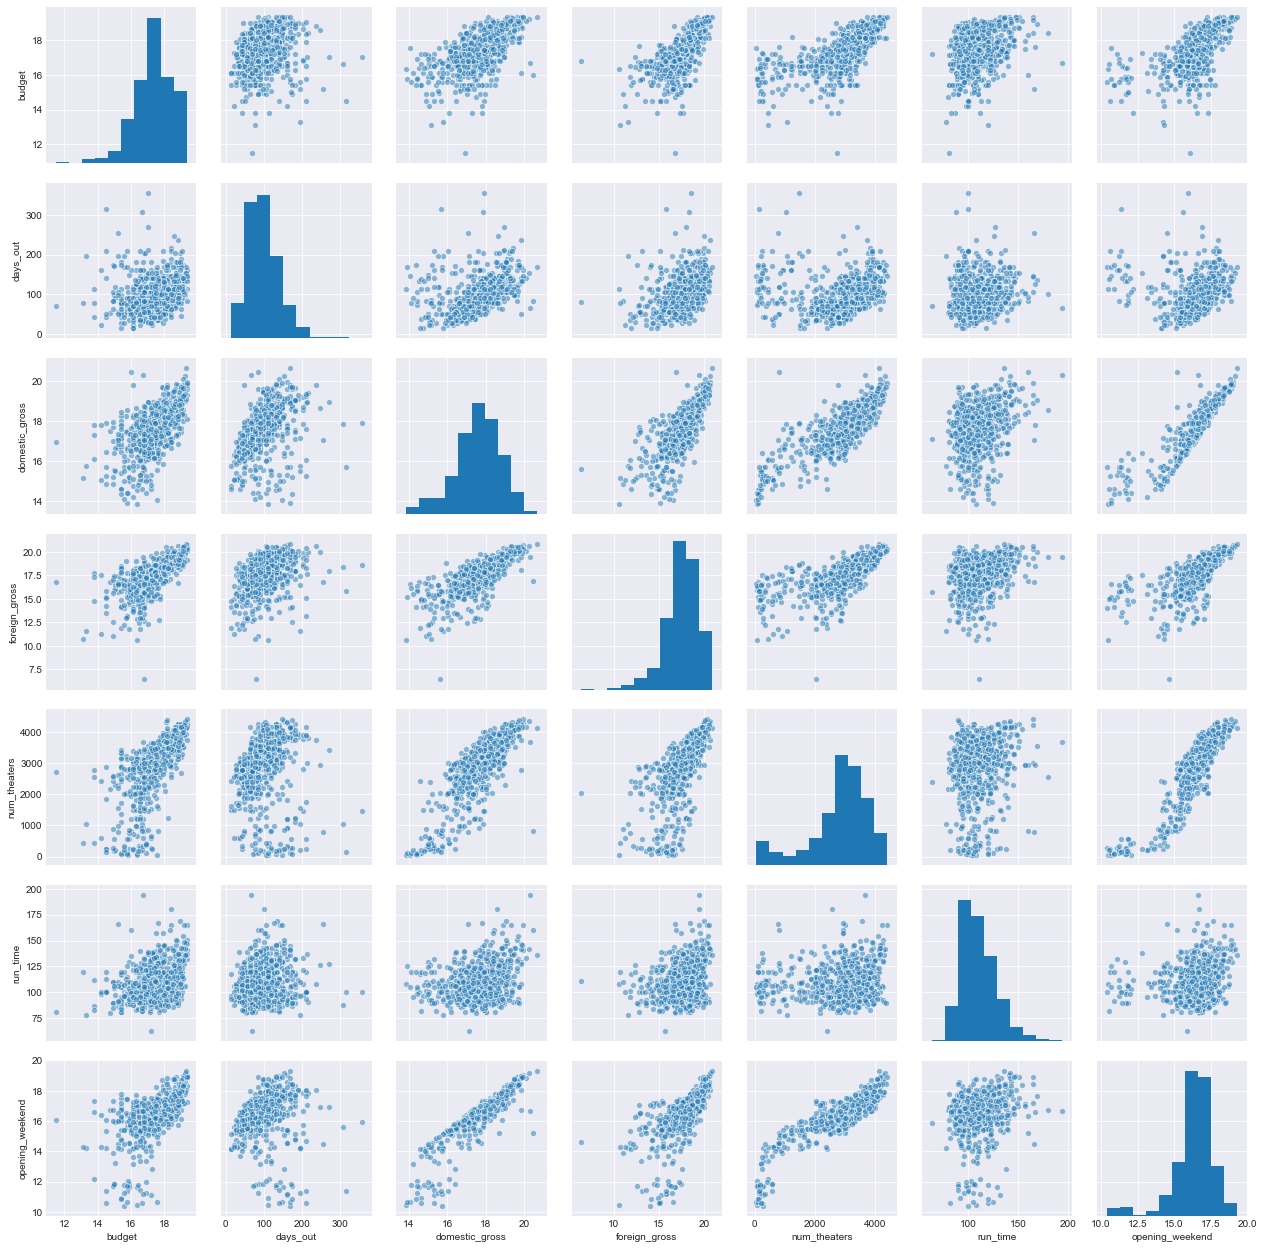

In [35]:
sns.pairplot(no_countries_log, plot_kws={'alpha':0.5});

In [36]:
no_countries.corr()

,budget,days_out,domestic_gross,foreign_gross,num_theaters,run_time,opening_weekend
budget,1.000000,0.260240,0.607492,0.786415,0.618526,0.371140,0.694807
days_out,0.260240,1.000000,0.391151,0.397647,0.086062,0.132488,0.313169
domestic_gross,0.607492,0.391151,1.000000,0.797284,0.519437,0.391229,0.863478
foreign_gross,0.786415,0.397647,0.797284,1.000000,0.552986,0.332874,0.839127
num_theaters,0.618526,0.086062,0.519437,0.552986,1.000000,0.137141,0.585897
run_time,0.371140,0.132488,0.391229,0.332874,0.137141,1.000000,0.306966
opening_weekend,0.694807,0.313169,0.863478,0.839127,0.585897,0.306966,1.000000


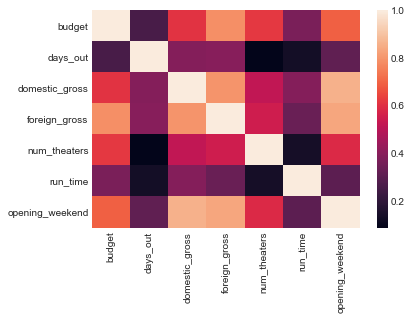

In [567]:
sns.heatmap(no_countries.corr())

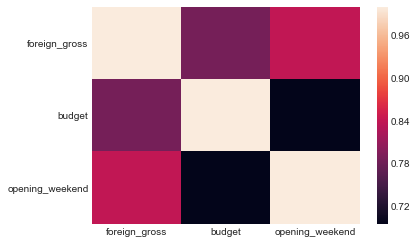

In [568]:
sns.heatmap(no_countries[['foreign_gross', 'budget', 'opening_weekend']].corr())

# Preliminary Models: Predicting Total Foreign Gross

### OLS Foreign Gross (only numerical variables)

In [38]:
lm = smf.ols('foreign_gross ~ domestic_gross + budget + days_out + num_theaters + run_time + opening_weekend', data=no_countries)
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     475.0
Date:                Wed, 04 Oct 2017   Prob (F-statistic):          4.22e-235
Time:                        15:33:10   Log-Likelihood:                -12941.
No. Observations:                 664   AIC:                         2.590e+04
Df Residuals:                     657   BIC:                         2.593e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.637e+07   2.34e+07     -1.127      0.260   -7.23e+07    1.96e+07
domestic_gross      0.4076      0.061      6.711      0.000       0.288       0.527
budget              1.1775      0.078     15.157      0.000       1.025       1.330
days_out         3.504e+05   6.83e+04      5.127      0.000    2.16e+05    4.85e+05
num_theaters    -4658.3103   3817.594     -1.220      0.223   -1.22e+04    2837.845
run_time        -2.426e+05   1.81e+05     -1.340      0.181   -5.98e+05    1.13e+05
opening_weekend     1.8811      0.206      9.116      0.000       1.476       2.286
==============================================================================
Omnibus:                      229.837   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1945.556
Skew:                           1.300   Prob(JB):                         0.00
Kurtosis:                      10.973   Cond. No.                     1.24e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### OLS log(Foreign Gross)

In [39]:
lm_log = smf.ols("foreign_gross ~ domestic_gross + budget + days_out + num_theaters + run_time + opening_weekend", data=no_countries_log)
fit_log = lm_log.fit()
fit_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     215.7
Date:                Wed, 04 Oct 2017   Prob (F-statistic):          1.18e-151
Time:                        15:33:27   Log-Likelihood:                -981.59
No. Observations:                 664   AIC:                             1977.
Df Residuals:                     657   BIC:                             2009.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.8705      1.330     -3.663      0.000      -7.481      -2.260
domestic_gross      0.8255      0.113      7.313      0.000       0.604       1.047
budget              0.5564      0.054     10.319      0.000       0.451       0.662
days_out            0.0039      0.001      2.957      0.003       0.001       0.006
num_theaters        0.0002      0.000      2.198      0.028    2.48e-05       0.000
run_time           -0.0013      0.003     -0.477      0.633      -0.007       0.004
opening_weekend    -0.1676      0.093     -1.800      0.072      -0.350       0.015
==============================================================================
Omnibus:                      286.526   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2745.863
Skew:                          -1.665   Prob(JB):                         0.00
Kurtosis:                      12.389   Cond. No.                     9.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### OLS Foreign Gross (incl. categorical variables)

In [51]:
lm_2 = smf.ols('foreign_gross ~ domestic_gross + budget + opening_weekend + days_out + num_theaters + run_time + genre + rating + distributor +month', data=no_countries)
fit_2 = lm_2.fit()
fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     87.17
Date:                Wed, 04 Oct 2017   Prob (F-statistic):          1.12e-215
Time:                        15:43:07   Log-Likelihood:                -12910.
No. Observations:                 664   AIC:                         2.589e+04
Df Residuals:                     628   BIC:                         2.605e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -6.073e+07   3.86e+07     -1.573      0.116   -1.37e+08    1.51e+07
genre[T.Comedy]            -2.055e+07    9.3e+06     -2.210      0.027   -3.88e+07   -2.29e+06
genre[T.Documentary]       -2.657e+07   3.93e+07     -0.677      0.499   -1.04e+08    5.06e+07
genre[T.Drama]             -1.589e+07   9.59e+06     -1.657      0.098   -3.47e+07    2.94e+06
genre[T.Family]             1.631e+07    1.5e+07      1.087      0.277   -1.32e+07    4.58e+07
genre[T.Horror]             1.044e+07   1.39e+07      0.749      0.454   -1.69e+07    3.78e+07
genre[T.Other]              1.152e+07   2.24e+07      0.513      0.608   -3.26e+07    5.56e+07
genre[T.Thriller]          -8.672e+06   1.28e+07     -0.680      0.497   -3.37e+07    1.64e+07
rating[T.PG]                1.616e+07   2.63e+07      0.615      0.539   -3.55e+07    6.78e+07
rating[T.PG-13]             1.468e+07   2.86e+07      0.513      0.608   -4.15e+07    7.08e+07
rating[T.R]                 2.158e+07   2.88e+07      0.748      0.455    -3.5e+07    7.82e+07
distributor[T.Fox]          3.368e+07   1.28e+07      2.639      0.009    8.62e+06    5.87e+07
distributor[T.Independent]  1.887e+07   1.39e+07      1.360      0.174   -8.38e+06    4.61e+07
distributor[T.Lionsgate]    6.034e+06   1.45e+07      0.417      0.676   -2.24e+07    3.44e+07
distributor[T.Paramount]    3.529e+07   1.41e+07      2.501      0.013    7.58e+06     6.3e+07
distributor[T.Sony]         1.276e+07   1.29e+07      0.988      0.324   -1.26e+07    3.81e+07
distributor[T.Universal]    1.891e+07   1.34e+07      1.413      0.158   -7.37e+06    4.52e+07
distributor[T.Warner Bros]  1.131e+06   1.31e+07      0.086      0.931   -2.47e+07    2.69e+07
distributor[T.Weinstein]    2.339e+07   1.87e+07      1.253      0.211   -1.33e+07       6e+07
month[T.August]            -1.344e+07   1.36e+07     -0.992      0.322      -4e+07    1.32e+07
month[T.December]          -1.473e+06   1.36e+07     -0.109      0.914   -2.81e+07    2.52e+07
month[T.February]            -3.1e+06   1.42e+07     -0.218      0.827    -3.1e+07    2.48e+07
month[T.January]             1.89e+06   1.44e+07      0.131      0.896   -2.64e+07    3.02e+07
month[T.July]               1.633e+07   1.37e+07      1.196      0.232   -1.05e+07    4.32e+07
month[T.June]              -4.945e+06   1.45e+07     -0.342      0.733   -3.34e+07    2.35e+07
month[T.March]              -2.95e+07   1.39e+07     -2.124      0.034   -5.68e+07   -2.23e+06
month[T.May]                1.754e+07    1.5e+07      1.167      0.244    -1.2e+07     4.7e+07
month[T.November]           1.499e+07   1.35e+07      1.108      0.268   -1.16e+07    4.16e+07
month[T.October]            1.119e+07   1.35e+07      0.830      0.407   -1.53e+07    3.77e+07
month[T.September]           4.53e+06   1.3

### OLS log(Foreign Gross) (incl. categorical variables)

In [41]:
lm_2_log = smf.ols('foreign_gross ~ domestic_gross + budget + opening_weekend + days_out + num_theaters + run_time + genre + rating + distributor + month', data=no_countries_log)
fit_2_log = lm_2_log.fit()
fit_2_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     46.68
Date:                Wed, 04 Oct 2017   Prob (F-statistic):          2.51e-150
Time:                        15:34:49   Log-Likelihood:                -917.60
No. Observations:                 664   AIC:                             1907.
Df Residuals:                     628   BIC:                             2069.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -6.7739      1.529     -4.430      0.000      -9.776      -3.771
genre[T.Comedy]               -0.6320      0.126     -4.999      0.000      -0.880      -0.384
genre[T.Documentary]           0.4181      0.563      0.743      0.458      -0.687       1.523
genre[T.Drama]                -0.1891      0.132     -1.437      0.151      -0.448       0.069
genre[T.Family]               -0.1639      0.215     -0.762      0.446      -0.586       0.258
genre[T.Horror]                0.8368      0.207      4.036      0.000       0.430       1.244
genre[T.Other]                -0.1084      0.318     -0.340      0.734      -0.733       0.517
genre[T.Thriller]             -0.0558      0.180     -0.310      0.757      -0.409       0.298
rating[T.PG]                   0.2746      0.378      0.727      0.468      -0.467       1.017
rating[T.PG-13]                0.7145      0.410      1.741      0.082      -0.091       1.520
rating[T.R]                    1.0034      0.414      2.425      0.016       0.191       1.816
distributor[T.Fox]             0.2384      0.178      1.336      0.182      -0.112       0.589
distributor[T.Independent]    -0.0006      0.197     -0.003      0.997      -0.387       0.386
distributor[T.Lionsgate]       0.1954      0.205      0.953      0.341      -0.207       0.598
distributor[T.Paramount]       0.1813      0.203      0.896      0.371      -0.216       0.579
distributor[T.Sony]           -0.0232      0.185     -0.126      0.900      -0.386       0.340
distributor[T.Universal]       0.2259      0.190      1.189      0.235      -0.147       0.599
distributor[T.Warner Bros]     0.0877      0.186      0.471      0.638      -0.278       0.453
distributor[T.Weinstein]       0.2517      0.265      0.951      0.342      -0.268       0.772
month[T.August]               -0.1733      0.194     -0.892      0.373      -0.555       0.208
month[T.December]             -0.1745      0.197     -0.885      0.376      -0.562       0.213
month[T.February]             -0.0301      0.203     -0.148      0.882      -0.429       0.369
month[T.January]               0.1133      0.206      0.549      0.583      -0.292       0.518
month[T.July]                  0.1405      0.194      0.724      0.470      -0.241       0.522
month[T.June]                 -0.3464      0.205     -1.687      0.092      -0.750       0.057
month[T.March]                -0.1400      0.198     -0.707      0.480      -0.529       0.249
month[T.May]                  -0.1491      0.212     -0.705      0.481      -0.565       0.266
month[T.November]             -0.1300      0.194     -0.670      0.503      -0.511       0.251
month[T.October]              -0.0856      0.193     -0.443      0.658      -0.465       0.293
month[T.September]            -0.0132      

In [42]:
no_countries.to_pickle('no_countries.pkl')

### Add dummy variables back in

In [43]:
df = pd.read_pickle('no_countries.pkl')

In [236]:
sep_genre = patsy.dmatrix('genre',data=df,return_type='dataframe')
df = df.join(sep_genre)
df.head(1)

,title,distributor,genre,rating,month,budget,days_out,domestic_gross,foreign_gross,num_theaters,run_time,Intercept,genre[T.Comedy],genre[T.Documentary],genre[T.Drama],genre[T.Family],genre[T.Horror],genre[T.Other],genre[T.Thriller]
0,12 Years a Slave,Fox,Drama,R,October,16.811243,203.0,17.852791,18.691175,1474,133.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [237]:
act_adv = df.genre == 'Action-Adventure'
act_adv = act_adv.astype(int)
df['genre[T.Action_Adventure]'] = act_adv
df.drop('Intercept', axis=1, inplace=True)
df.head(1)

,title,distributor,genre,rating,month,budget,days_out,domestic_gross,foreign_gross,num_theaters,run_time,genre[T.Comedy],genre[T.Documentary],genre[T.Drama],genre[T.Family],genre[T.Horror],genre[T.Other],genre[T.Thriller],genre[T.Action_Adventure]
0,12 Years a Slave,Fox,Drama,R,October,16.811243,203.0,17.852791,18.691175,1474,133.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [238]:
sep_rating = patsy.dmatrix('rating',data=df,return_type='dataframe')
df = df.join(sep_rating)
df.columns

Index(['title', 'distributor', 'genre', 'rating', 'month', 'budget',
       'days_out', 'domestic_gross', 'foreign_gross', 'num_theaters',
       'run_time', 'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'Intercept',
       'rating[T.PG]', 'rating[T.PG-13]', 'rating[T.R]'],
      dtype='object')

In [239]:
g_rated = df.rating == 'G'
g_rated = g_rated.astype(int)
df['rating[T.G]'] = g_rated
df.drop('Intercept', axis=1, inplace=True)
df.columns

Index(['title', 'distributor', 'genre', 'rating', 'month', 'budget',
       'days_out', 'domestic_gross', 'foreign_gross', 'num_theaters',
       'run_time', 'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]'],
      dtype='object')

In [240]:
sep_dist = patsy.dmatrix('distributor',data=df,return_type='dataframe')
df = df.join(sep_dist)
df.columns

Index(['title', 'distributor', 'genre', 'rating', 'month', 'budget',
       'days_out', 'domestic_gross', 'foreign_gross', 'num_theaters',
       'run_time', 'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'Intercept',
       'distributor[T.Fox]', 'distributor[T.Independent]',
       'distributor[T.Lionsgate]', 'distributor[T.Paramount]',
       'distributor[T.Sony]', 'distributor[T.Universal]',
       'distributor[T.Warner Bros]', 'distributor[T.Weinstein]'],
      dtype='object')

In [241]:
disney = df.distributor == 'Disney'
disney = disney.astype(int)
df['distributor[T.Disney]'] = disney
df.drop('Intercept', axis=1, inplace=True)
df.columns

Index(['title', 'distributor', 'genre', 'rating', 'month', 'budget',
       'days_out', 'domestic_gross', 'foreign_gross', 'num_theaters',
       'run_time', 'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'distributor[T.Fox]',
       'distributor[T.Independent]', 'distributor[T.Lionsgate]',
       'distributor[T.Paramount]', 'distributor[T.Sony]',
       'distributor[T.Universal]', 'distributor[T.Warner Bros]',
       'distributor[T.Weinstein]', 'distributor[T.Disney]'],
      dtype='object')

In [242]:
sep_month = patsy.dmatrix('month',data=df,return_type='dataframe')
df = df.join(sep_month)
df.columns

Index(['title', 'distributor', 'genre', 'rating', 'month', 'budget',
       'days_out', 'domestic_gross', 'foreign_gross', 'num_theaters',
       'run_time', 'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'distributor[T.Fox]',
       'distributor[T.Independent]', 'distributor[T.Lionsgate]',
       'distributor[T.Paramount]', 'distributor[T.Sony]',
       'distributor[T.Universal]', 'distributor[T.Warner Bros]',
       'distributor[T.Weinstein]', 'distributor[T.Disney]', 'Intercept',
       'month[T.August]', 'month[T.December]', 'month[T.February]',
       'month[T.January]', 'month[T.July]', 'month[T.June]', 'month[T.March]',
       'month[T.May]', 'month[T.November]', 'month[T.October]',
       'month[T.September]'],
      dtype='object')

In [243]:
apr = df.month == 'April'
apr = apr.astype(int)
df['month[T.April]'] = apr
df.drop('Intercept', axis=1, inplace=True)
df.columns

Index(['title', 'distributor', 'genre', 'rating', 'month', 'budget',
       'days_out', 'domestic_gross', 'foreign_gross', 'num_theaters',
       'run_time', 'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'distributor[T.Fox]',
       'distributor[T.Independent]', 'distributor[T.Lionsgate]',
       'distributor[T.Paramount]', 'distributor[T.Sony]',
       'distributor[T.Universal]', 'distributor[T.Warner Bros]',
       'distributor[T.Weinstein]', 'distributor[T.Disney]', 'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]'],
      dtype='object')

In [44]:
def add_dummy_vars(df):
    sep_genre = patsy.dmatrix('genre',data=df,return_type='dataframe')
    df = df.join(sep_genre)
    act_adv = df.genre == 'Action-Adventure'
    act_adv = act_adv.astype(int)
    df['genre[T.Action_Adventure]'] = act_adv
    df.drop('Intercept', axis=1, inplace=True)
    sep_rating = patsy.dmatrix('rating',data=df,return_type='dataframe')
    df = df.join(sep_rating)
    g_rated = df.rating == 'G'
    g_rated = g_rated.astype(int)
    df['rating[T.G]'] = g_rated
    df.drop('Intercept', axis=1, inplace=True)
    sep_dist = patsy.dmatrix('distributor',data=df,return_type='dataframe')
    df = df.join(sep_dist)
    disney = df.distributor == 'Disney'
    disney = disney.astype(int)
    df['distributor[T.Disney]'] = disney
    df.drop('Intercept', axis=1, inplace=True)
    sep_month = patsy.dmatrix('month',data=df,return_type='dataframe')
    df = df.join(sep_month)
    apr = df.month == 'April'
    apr = apr.astype(int)
    df['month[T.April]'] = apr
    df.drop('Intercept', axis=1, inplace=True)
    return df

In [45]:
df = add_dummy_vars(df)

In [46]:
df.columns

Index(['title', 'distributor', 'genre', 'rating', 'month', 'budget',
       'days_out', 'domestic_gross', 'foreign_gross', 'num_theaters',
       'run_time', 'opening_weekend', 'genre[T.Comedy]',
       'genre[T.Documentary]', 'genre[T.Drama]', 'genre[T.Family]',
       'genre[T.Horror]', 'genre[T.Other]', 'genre[T.Thriller]',
       'genre[T.Action_Adventure]', 'rating[T.PG]', 'rating[T.PG-13]',
       'rating[T.R]', 'rating[T.G]', 'distributor[T.Fox]',
       'distributor[T.Independent]', 'distributor[T.Lionsgate]',
       'distributor[T.Paramount]', 'distributor[T.Sony]',
       'distributor[T.Universal]', 'distributor[T.Warner Bros]',
       'distributor[T.Weinstein]', 'distributor[T.Disney]', 'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]'],
      dtype='object')

In [47]:
df.to_pickle('no_countries_catvars.pkl')

## More OLS Regression Models (dropping domestic gross, runtime, days out, and number of theaters)

### sklearn

In [569]:
df = pd.read_pickle('no_countries_catvars.pkl')

In [570]:
df.at[df.title == 'Chasing Mavericks', 'foreign_gross'] = 193930

In [571]:
df[df.title == 'Chasing Mavericks']

,title,distributor,genre,rating,month,budget,days_out,domestic_gross,foreign_gross,num_theaters,...,month[T.February],month[T.January],month[T.July],month[T.June],month[T.March],month[T.May],month[T.November],month[T.October],month[T.September],month[T.April]
83,Chasing Mavericks,Fox,Drama,PG,October,20000000.0,80.0,6002756,193930.0,2030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


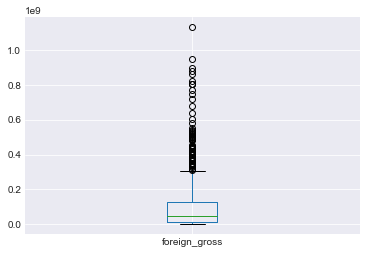

In [572]:
df.boxplot(column=['foreign_gross'])

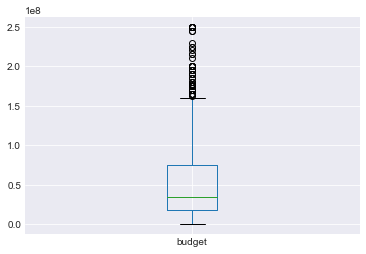

In [573]:
df.boxplot(column=['budget'])

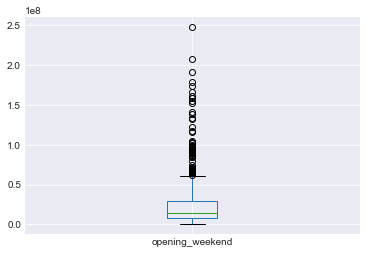

In [574]:
df.boxplot(column=['opening_weekend'])

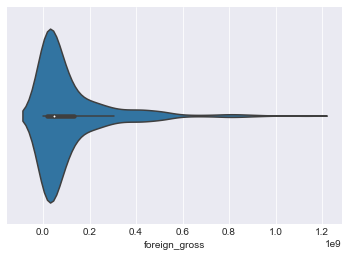

In [575]:
sns.violinplot('foreign_gross', data=df)


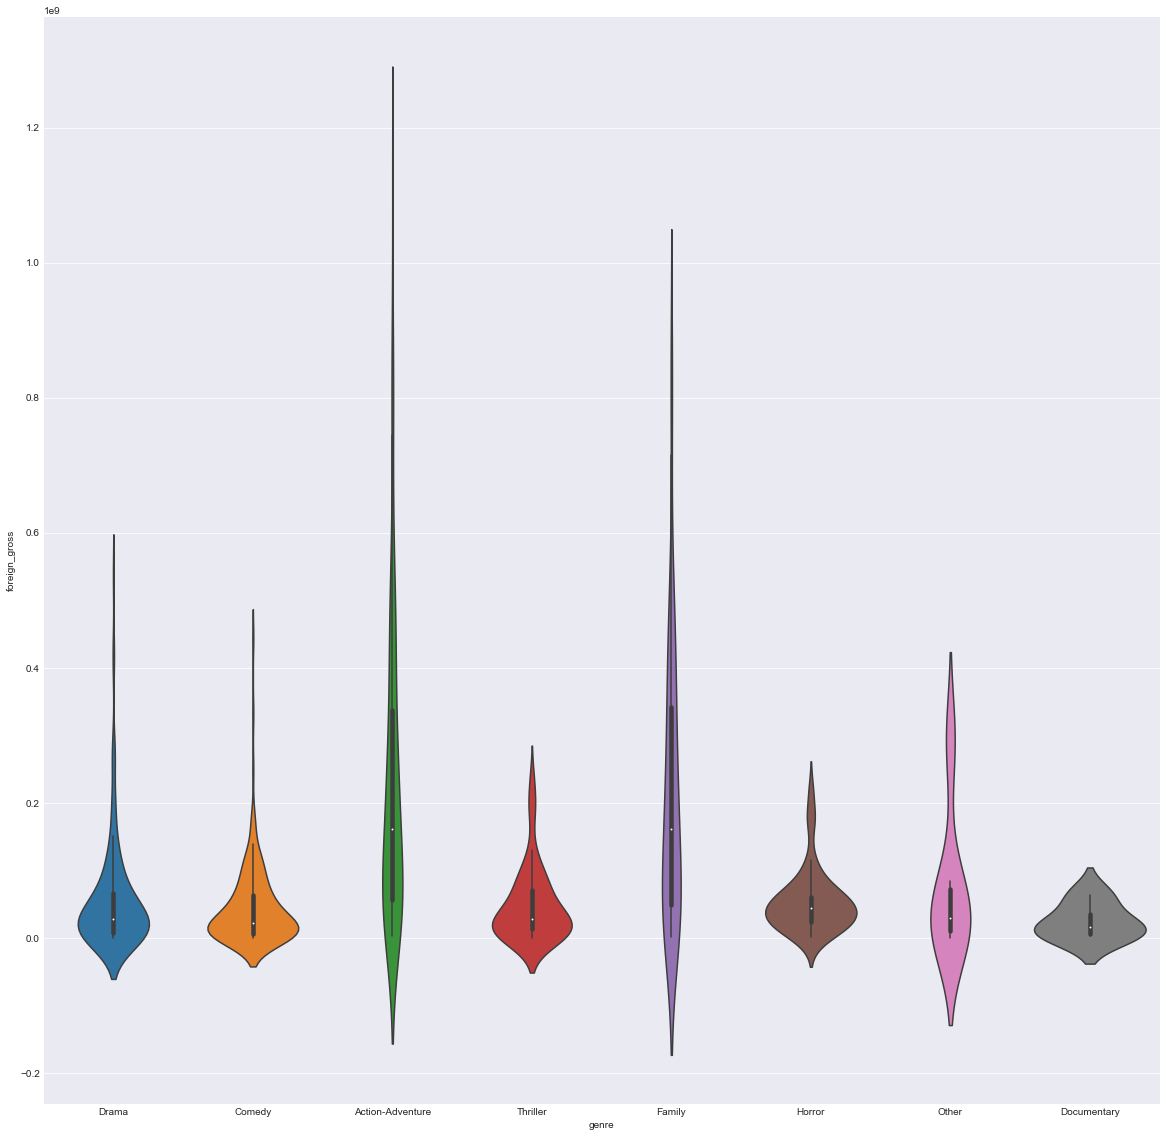

In [579]:
plt.figure(figsize=(20,20))
sns.violinplot('genre', 'foreign_gross', data=df)

In [457]:
df[[ 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]',  'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]']].corr()

,genre[T.Comedy],genre[T.Documentary],genre[T.Drama],genre[T.Family],genre[T.Horror],genre[T.Other],genre[T.Thriller],genre[T.Action_Adventure],month[T.August],month[T.December],month[T.February],month[T.January],month[T.July],month[T.June],month[T.March],month[T.May],month[T.November],month[T.October],month[T.September],month[T.April]
genre[T.Comedy],1.000000,-0.046030,-0.319408,-0.198076,-0.153642,-0.080214,-0.159420,-0.349593,-0.027583,-0.001107,-0.019032,0.028217,0.044905,0.030337,-0.012425,0.082369,0.002366,-0.067525,-0.042471,-0.002722
genre[T.Documentary],-0.046030,1.000000,-0.042055,-0.026080,-0.020230,-0.010561,-0.020990,-0.046030,-0.024311,-0.025863,0.053423,-0.021239,0.044090,-0.021974,-0.023163,-0.021239,-0.024761,0.039848,-0.024537,0.050634
genre[T.Drama],-0.319408,-0.042055,1.000000,-0.180973,-0.140376,-0.073288,-0.145655,-0.319408,-0.016813,0.133495,0.002178,-0.005554,-0.092756,-0.042281,-0.028971,-0.062286,0.015210,0.028071,0.043285,0.006477
genre[T.Family],-0.198076,-0.026080,-0.180973,1.000000,-0.087052,-0.045448,-0.090326,-0.198076,0.000820,-0.011024,-0.035591,-0.052015,0.071111,0.020191,0.010083,-0.012633,0.031937,-0.043053,0.016495,-0.002743
genre[T.Horror],-0.153642,-0.020230,-0.140376,-0.087052,1.000000,-0.035253,-0.070063,-0.153642,0.049318,-0.065649,-0.048646,0.075298,0.005829,-0.002352,-0.077315,-0.046529,-0.082649,0.164239,-0.017160,0.041220
genre[T.Other],-0.080214,-0.010561,-0.073288,-0.045448,-0.035253,1.000000,-0.036579,-0.080214,0.076833,0.106074,-0.037870,-0.037013,-0.042366,0.048193,-0.040364,-0.037013,-0.004008,0.031398,-0.042759,-0.039131
genre[T.Thriller],-0.159420,-0.020990,-0.145655,-0.090326,-0.070063,-0.036579,1.000000,-0.159420,0.021090,-0.009470,0.017283,0.020824,-0.042084,-0.030270,-0.014460,-0.049964,-0.002780,0.092645,0.040413,-0.055270
genre[T.Action_Adventure],-0.349593,-0.046030,-0.319408,-0.198076,-0.153642,-0.080214,-0.159420,1.000000,-0.015502,-0.104512,0.060614,-0.025934,0.020742,0.004040,0.100763,0.055293,0.014267,-0.090661,-0.006501,0.010188
month[T.August],-0.027583,-0.024311,-0.016813,0.000820,0.049318,0.076833,0.021090,-0.015502,1.000000,-0.103746,-0.087172,-0.085199,-0.097521,-0.088147,-0.092914,-0.085199,-0.099324,-0.102871,-0.098425,-0.090075
month[T.December],-0.001107,-0.025863,0.133495,-0.011024,-0.065649,0.106074,-0.009470,-0.104512,-0.103746,1.000000,-0.092737,-0.090637,-0.103746,-0.093774,-0.098845,-0.090637,-0.105664,-0.109437,-0.104708,-0.095824


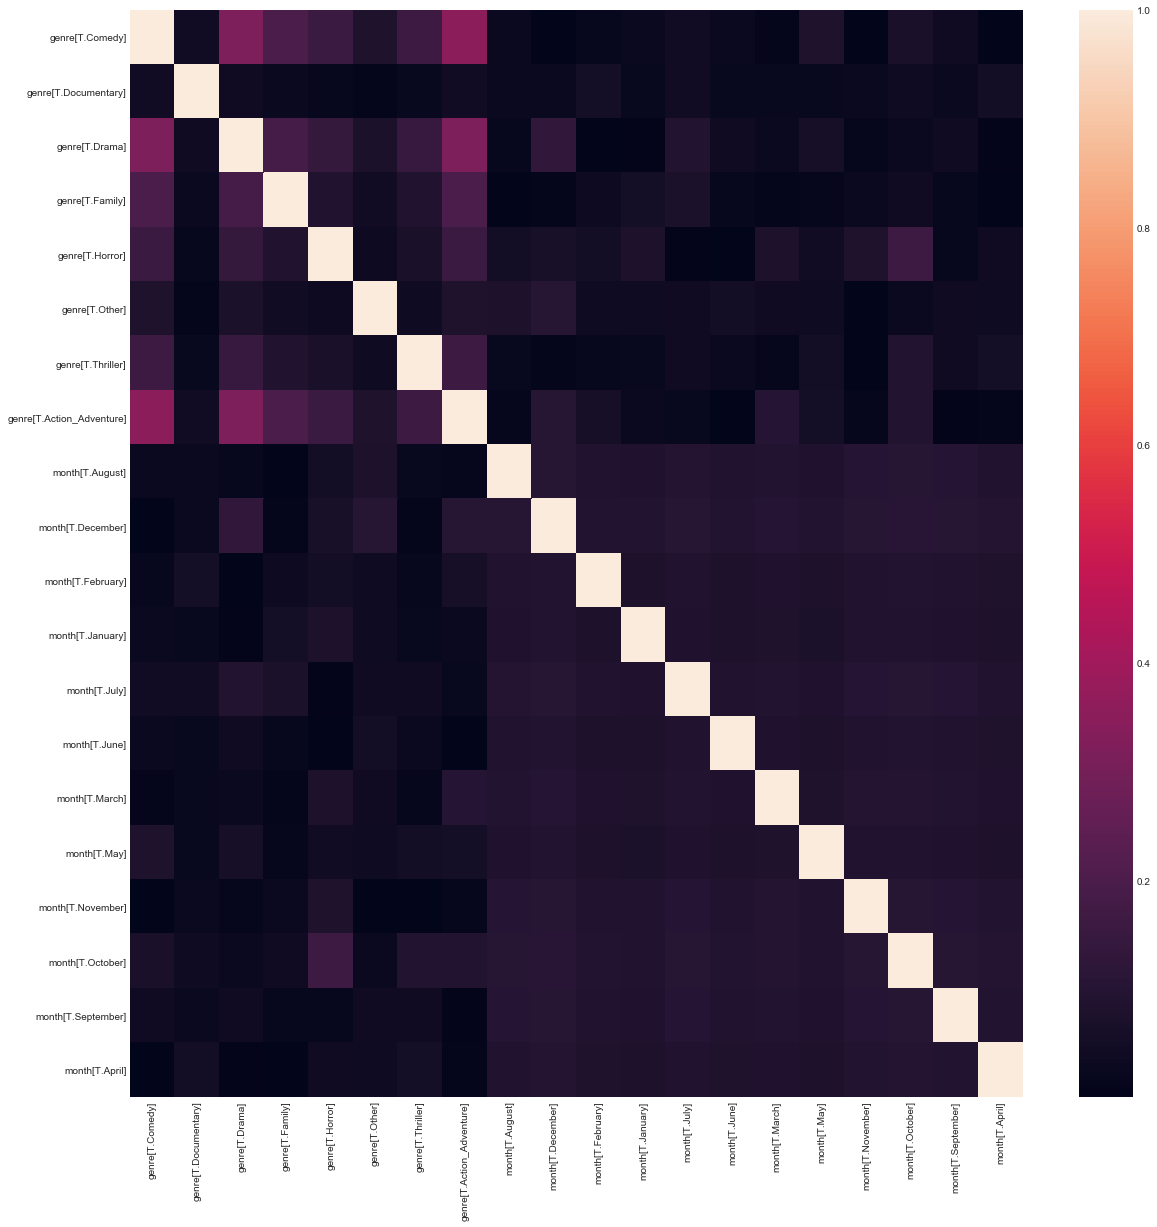

In [458]:
fig = plt.figure(figsize = (20,20))
sns.heatmap(abs(df[[ 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]',  'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]']].corr()))

In [459]:
model = LinearRegression()
X = df[['budget', 'opening_weekend',
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'distributor[T.Fox]',
       'distributor[T.Independent]', 'distributor[T.Lionsgate]',
       'distributor[T.Paramount]', 'distributor[T.Sony]',
       'distributor[T.Universal]', 'distributor[T.Warner Bros]',
       'distributor[T.Weinstein]', 'distributor[T.Disney]', 'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]']]
y = df['foreign_gross']
model.fit(X,y)
print(model.score(X,y))
print(model.intercept_, model.coef_)

0.808392894574
-25381715.1074 [  1.03058615e+00   3.10817732e+00  -1.85447241e+07  -1.21528688e+07
  -7.01538309e+06   3.50593333e+07  -1.86283672e+05   7.23439433e+06
  -9.99656514e+06   5.60209717e+06   6.68575536e+06   4.21624244e+06
   1.21684933e+07  -2.30704911e+07   2.38955757e+07  -2.38519724e+06
  -1.60554987e+07   1.63195332e+07  -1.62397126e+06  -4.87207777e+06
  -2.21525756e+07   1.29667823e+07  -6.09257062e+06  -1.39834860e+07
   8.81243823e+06  -1.14266033e+07  -7.08604944e+06   1.73444484e+07
  -5.79831811e+06  -3.19282470e+07   1.73889411e+07   1.95660955e+07
   8.56684081e+06  -4.48766096e+06   3.03160082e+06]


### statsmodels

In [460]:
y = df['foreign_gross']
X = df[['budget', 'opening_weekend',
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'distributor[T.Fox]',
       'distributor[T.Independent]', 'distributor[T.Lionsgate]',
       'distributor[T.Paramount]', 'distributor[T.Sony]',
       'distributor[T.Universal]', 'distributor[T.Warner Bros]',
       'distributor[T.Weinstein]', 'distributor[T.Disney]', 'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]']]
#X['intercept'] = 1
X = sm.add_constant(X, prepend=True)
model2 = sm.OLS(y,X)
fitnew = model2.fit()
fitnew.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     86.01
Date:                Wed, 04 Oct 2017   Prob (F-statistic):          6.03e-204
Time:                        22:11:01   Log-Likelihood:                -12949.
No. Observations:                 664   AIC:                         2.596e+04
Df Residuals:                     632   BIC:                         2.611e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -1.617e+07   5.66e+06     -2.857      0.004   -2.73e+07   -5.06e+06
budget                         1.0306      0.089     11.538      0.000       0.855       1.206
opening_weekend                3.1082      0.136     22.936      0.000       2.842       3.374
genre[T.Comedy]            -2.057e+07    8.3e+06     -2.478      0.013   -3.69e+07   -4.27e+06
genre[T.Documentary]       -1.417e+07   3.53e+07     -0.402      0.688   -8.34e+07    5.51e+07
genre[T.Drama]             -9.037e+06   8.52e+06     -1.061      0.289   -2.58e+07    7.69e+06
genre[T.Family]             3.304e+07   1.23e+07      2.678      0.008    8.81e+06    5.73e+07
genre[T.Horror]            -2.208e+06   1.25e+07     -0.177      0.860   -2.67e+07    2.23e+07
genre[T.Other]              5.213e+06   1.99e+07      0.261      0.794    -3.4e+07    4.44e+07
genre[T.Thriller]          -1.202e+07    1.2e+07     -0.999      0.318   -3.56e+07    1.16e+07
genre[T.Action_Adventure]   3.581e+06    9.6e+06      0.373      0.709   -1.53e+07    2.24e+07
rating[T.PG]                2.643e+06   8.85e+06      0.298      0.765   -1.47e+07       2e+07
rating[T.PG-13]             1.731e+05   8.87e+06      0.020      0.984   -1.72e+07    1.76e+07
rating[T.R]                 8.125e+06   9.05e+06      0.898      0.370   -9.65e+06    2.59e+07
rating[T.G]                -2.711e+07   2.24e+07     -1.210      0.227   -7.11e+07    1.69e+07
distributor[T.Fox]           2.21e+07   7.68e+06      2.878      0.004    7.02e+06    3.72e+07
distributor[T.Independent] -4.182e+06   7.97e+06     -0.525      0.600   -1.98e+07    1.15e+07
distributor[T.Lionsgate]   -1.785e+07   9.18e+06     -1.946      0.052   -3.59e+07    1.67e+05
distributor[T.Paramount]    1.452e+07   9.13e+06      1.591      0.112    -3.4e+06    3.24e+07
distributor[T.Sony]        -3.421e+06   7.37e+06     -0.464      0.643   -1.79e+07    1.11e+07
distributor[T.Universal]   -6.669e+06   7.56e+06     -0.882      0.378   -2.15e+07    8.18e+06
distributor[T.Warner Bros] -2.395e+07   7.56e+06     -3.168      0.002   -3.88e+07   -9.11e+06
distributor[T.Weinstein]    1.117e+07   1.43e+07      0.782      0.435   -1.69e+07    3.92e+07
distributor[T.Disney]       -7.89e+06   1.06e+07     -0.745      0.457   -2.87e+07    1.29e+07
month[T.August]            -1.533e+07   9.28e+06     -1.653      0.099   -3.35e+07    2.89e+06
month[T.December]           7.465e+06   9.01e+06      0.829      0.408   -1.02e+07    2.52e+07
month[T.February]          -1.277e+07   1.02e+07     -1.251      0.211   -3.28e+07    7.27e+06
month[T.January]           -8.434e+06   1.05e+07     -0.801      0.423   -2.91e+07    1.22e+07
month[T.July]                 1.6e+07   9.35e+06      1.710      0.088   -2.37e+06    3.44e+07
month[T.June]              -7.146e+06   1.0

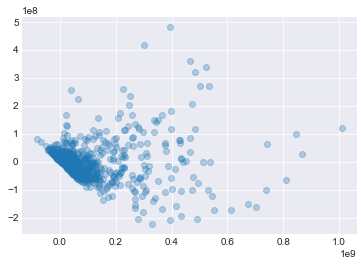

In [461]:
plt.scatter(fitnew.predict(X), df.foreign_gross-fitnew.predict(X), alpha=0.3)
#plt.xlim((-0.5e8,1.5e8))

In [462]:
import scipy.stats as stats

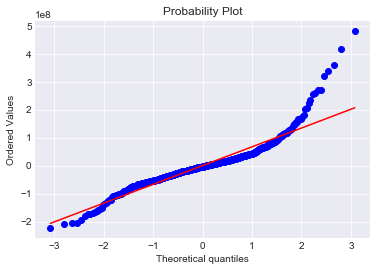

In [463]:
stats.probplot(df.foreign_gross-fitnew.predict(X), dist="norm", plot=plt)
plt.show()

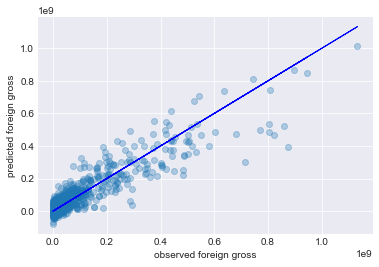

In [465]:
plt.scatter(y,fitnew.predict(X), alpha=0.3)
plt.plot(y, y, color='blue',linewidth=1)
plt.xlabel("observed foreign gross")
plt.ylabel("predicted foreign gross")

## K Folds Cross Validation with Selection of Columns

In [358]:
def find_sig_cols(X, y, alpha=0.05):
    sig_cols = []
    for c in X.columns:
        pvalue = f_select.f_regression(X[[c]], y)[1][0]
        if pvalue <= alpha:
            sig_cols.append(c)
    return sig_cols

In [580]:
df = pd.read_pickle('no_countries_catvars.pkl')

In [360]:
X = df[['budget', 'opening_weekend', 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'distributor[T.Fox]',
       'distributor[T.Independent]', 'distributor[T.Lionsgate]',
       'distributor[T.Paramount]', 'distributor[T.Sony]',
       'distributor[T.Universal]', 'distributor[T.Warner Bros]',
       'distributor[T.Weinstein]', 'distributor[T.Disney]', 'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]']]
y = df['foreign_gross']

In [361]:
from collections import defaultdict

In [362]:
n_folds = 10
kf = KFold(n=len(X), n_folds=n_folds, shuffle=True)
est = LinearRegression()

all_scores = []
all_sig_cols = []
coeffs = defaultdict(list)

for train_i, test_i in kf:
    x_train = X.iloc[train_i]
    y_train = y.iloc[train_i].reshape(-1, 1)
    x_test = X.iloc[test_i]
    y_test = y.iloc[test_i].reshape(-1, 1)

    sig_cols = find_sig_cols(x_train, y_train)
    for col in sig_cols:
        all_sig_cols.append(col)
    est.fit(x_train[sig_cols], y_train)
    r2 = est.score(x_test[sig_cols], y_test)
    all_scores.append(r2)
    #print(est.coef_)
    for col in sig_cols:
        coeffs[col].append(est.coef_[0][sig_cols.index(col)])

counter = Counter(all_sig_cols)
print(counter.most_common())
newcoeffs = defaultdict()
for item in counter:
    if counter[item] == n_folds:
        newcoeffs[item] = np.mean(coeffs[item])
print(newcoeffs)
np.mean(all_scores)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  del sys.path[0]
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('budget', 10), ('opening_weekend', 10), ('genre[T.Comedy]', 10), ('genre[T.Drama]', 10), ('genre[T.Family]', 10), ('genre[T.Horror]', 10), ('genre[T.Thriller]', 10), ('genre[T.Action_Adventure]', 10), ('rating[T.PG]', 10), ('rating[T.PG-13]', 10), ('rating[T.R]', 10), ('distributor[T.Independent]', 10), ('distributor[T.Disney]', 10), ('month[T.January]', 10), ('month[T.July]', 10), ('month[T.May]', 10), ('month[T.November]', 10), ('month[T.September]', 10), ('distributor[T.Paramount]', 9), ('month[T.August]', 8), ('distributor[T.Fox]', 7), ('month[T.October]', 7), ('month[T.June]', 6), ('distributor[T.Universal]', 1), ('distributor[T.Lionsgate]', 1), ('distributor[T.Weinstein]', 1)]
defaultdict(None, {'budget': 1.0253761206494878, 'opening_weekend': 3.0833806733811278, 'genre[T.Comedy]': -24730490.474107303, 'genre[T.Drama]': -10681798.194345469, 'genre[T.Family]': 31489922.839106012, 'genre[T.Horror]': -3665441.0275178044, 'genre[T.Thriller]': -14988243.742634824, 'genre[T.Action_Ad

0.75609872128873323

## Try eliminating features

In [584]:
df = pd.read_pickle('no_countries_catvars.pkl')

### no ratings

In [589]:
X = df[['budget', 'opening_weekend', 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'distributor[T.Fox]',
       'distributor[T.Independent]', 'distributor[T.Lionsgate]',
       'distributor[T.Paramount]', 'distributor[T.Sony]',
       'distributor[T.Universal]', 'distributor[T.Warner Bros]',
       'distributor[T.Weinstein]', 'distributor[T.Disney]', 'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]']]
y = df['foreign_gross']

In [590]:
X = sm.add_constant(X, prepend=True)
model2 = sm.OLS(y,X)
fitnew = model2.fit()
fitnew.rsquared_adj

0.79916608678249179

### no distributor

In [593]:
X = df[['budget', 'opening_weekend', 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]']]
y = df['foreign_gross']

In [594]:
X = sm.add_constant(X, prepend=True)
model2 = sm.OLS(y,X)
fitnew = model2.fit()
fitnew.rsquared_adj

0.79382782156671405

### no month

In [597]:
X = df[['budget', 'opening_weekend', 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'distributor[T.Fox]',
       'distributor[T.Independent]', 'distributor[T.Lionsgate]',
       'distributor[T.Paramount]', 'distributor[T.Sony]',
       'distributor[T.Universal]', 'distributor[T.Warner Bros]',
       'distributor[T.Weinstein]', 'distributor[T.Disney]']]
y = df['foreign_gross']

In [598]:
X = sm.add_constant(X, prepend=True)
model2 = sm.OLS(y,X)
fitnew = model2.fit()
fitnew.rsquared_adj

0.79450980197726662

### no ratings, no dist

In [599]:
X = df[['budget', 'opening_weekend', 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]',  'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]']]
y = df['foreign_gross']

In [600]:
X = sm.add_constant(X, prepend=True)
model2 = sm.OLS(y,X)
fitnew = model2.fit()
fitnew.rsquared_adj

0.79416471922343679

### no ratings, no month

In [603]:
X = df[['budget', 'opening_weekend', 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]',  'distributor[T.Fox]',
       'distributor[T.Independent]', 'distributor[T.Lionsgate]',
       'distributor[T.Paramount]', 'distributor[T.Sony]',
       'distributor[T.Universal]', 'distributor[T.Warner Bros]',
       'distributor[T.Weinstein]', 'distributor[T.Disney]']]
y = df['foreign_gross']

In [604]:
X = sm.add_constant(X, prepend=True)
model2 = sm.OLS(y,X)
fitnew = model2.fit()
fitnew.rsquared_adj

0.79483324283757151

### no dist, no month

In [605]:
X = df[['budget', 'opening_weekend', 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]']]
y = df['foreign_gross']

In [606]:
X = sm.add_constant(X, prepend=True)
model2 = sm.OLS(y,X)
fitnew = model2.fit()
fitnew.rsquared_adj

0.78829332005525332

### only genre

In [607]:
X = df[['budget', 'opening_weekend', 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]']]
y = df['foreign_gross']

In [608]:
X = sm.add_constant(X, prepend=True)
model2 = sm.OLS(y,X)
fitnew = model2.fit()
fitnew.rsquared_adj

0.78881977883595444

## Ridge Regression

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [167]:
rcv = RidgeCV(alphas=(1.0,1e-1,1e-2,1e-3,1e-4), cv=10)

In [ ]:
rcv.

In [172]:
rcv.fit(X_train, y_train)
rcv.score(X_test, y_test)

0.81188127790701725

In [159]:
rcv.fit(X, y)
rcv.score(X, y)

0.80838003892439048

## Lasso

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [239]:
# lcv = LassoCV(alphas=(1.0,1e-1,1e-2,1e-3,1e-4), cv=10)
lcv = LassoCV(alphas=np.logspace(-4,6,num=100), cv=10,normalize=True,)

In [240]:
lcv.fit(X_train, y_train)
lcv.score(X_test, y_test)

0.77722861170835622

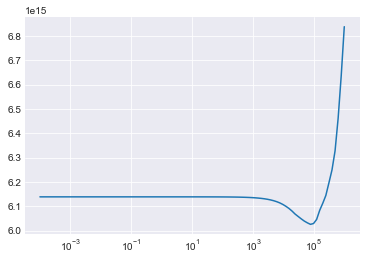

In [241]:
plt.plot(lcv.alphas_,lcv.mse_path_.mean(axis=1))
plt.xscale("log")

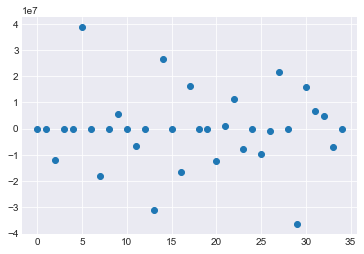

In [242]:
plt.scatter(range(len(lcv.coef_)),lcv.coef_)
# plt.set_xticks(X_train.columns)

In [210]:
lcv.fit(X, y)
lcv.score(X, y)

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.80839260844803007

# Final (?) Model

In [485]:
df = pd.read_pickle('no_countries_catvars.pkl')

In [486]:
X = df[['budget', 'opening_weekend', 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]']]
y = df['foreign_gross']

In [487]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [488]:
est = LinearRegression()
fit = est.fit(X_train, y_train)
fit.score(X_train, y_train)

0.80326906033245726

In [489]:
fit.score(X_test, y_test)

0.78547140412651562

In [490]:
print(list(zip(X.columns, fit.coef_)))

[('budget', 1.1260783661487483), ('opening_weekend', 2.9174389672214742), ('genre[T.Comedy]', -18778611.737621203), ('genre[T.Documentary]', -25394664.547060326), ('genre[T.Drama]', -6759065.3829885609), ('genre[T.Family]', 30727668.327668384), ('genre[T.Horror]', 446237.0870748125), ('genre[T.Other]', 19368378.947604392), ('genre[T.Thriller]', -3890926.4662570357), ('genre[T.Action_Adventure]', 4280983.7715795189), ('rating[T.PG]', 5156741.7548364839), ('rating[T.PG-13]', -5102101.9424427189), ('rating[T.R]', 1863033.1310891882), ('rating[T.G]', -1917672.9434828835), ('month[T.August]', -16502306.070849637), ('month[T.December]', 12213592.352692923), ('month[T.February]', -4159234.78033977), ('month[T.January]', -7534632.3309919927), ('month[T.July]', 16968047.379191957), ('month[T.June]', -5744634.0104358047), ('month[T.March]', -28667074.357005782), ('month[T.May]', 10476294.230806939), ('month[T.November]', 19195628.048489533), ('month[T.October]', 10142445.512491198), ('month[T.Se

In [491]:
df['predict'] = fit.predict(X)

In [492]:
df.head(1)

,title,distributor,genre,rating,month,budget,days_out,domestic_gross,foreign_gross,num_theaters,...,month[T.January],month[T.July],month[T.June],month[T.March],month[T.May],month[T.November],month[T.October],month[T.September],month[T.April],predict
0,12 Years a Slave,Fox,Drama,R,October,20000000.0,203.0,56671993,131061209.0,1474,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2.878408e+07


In [493]:
df['resid'] = df.foreign_gross - df.predict

In [494]:
df.head(1)

,title,distributor,genre,rating,month,budget,days_out,domestic_gross,foreign_gross,num_theaters,...,month[T.July],month[T.June],month[T.March],month[T.May],month[T.November],month[T.October],month[T.September],month[T.April],predict,resid
0,12 Years a Slave,Fox,Drama,R,October,20000000.0,203.0,56671993,131061209.0,1474,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2.878408e+07,1.022771e+08


In [495]:
df_sort = df.sort_values(by='resid', ascending=False)

In [496]:
df_sort.head()

,title,distributor,genre,rating,month,budget,days_out,domestic_gross,foreign_gross,num_theaters,...,month[T.July],month[T.June],month[T.March],month[T.May],month[T.November],month[T.October],month[T.September],month[T.April],predict,resid
158,Frozen,Disney,Family,PG,November,150000000.0,238.0,400738009,875742326.0,3742,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,4.021419e+08,4.736004e+08
214,Ice Age: Continental Drift,Fox,Family,PG,July,95000000.0,210.0,161321843,715922939.0,3886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.774080e+08,4.385150e+08
311,Minions,Universal,Family,PG,July,74000000.0,161.0,336045770,823352627.0,4311,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.553237e+08,3.680289e+08
621,Transformers: Age of Extinction,Paramount,Action-Adventure,PG-13,June,210000000.0,105.0,245439076,858614996.0,4233,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,5.033067e+08,3.553083e+08
430,Skyfall,Sony,Action-Adventure,PG-13,November,200000000.0,122.0,304360277,804200736.0,3526,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,4.829289e+08,3.212718e+08


In [497]:
df_sort.tail()

,title,distributor,genre,rating,month,budget,days_out,domestic_gross,foreign_gross,num_theaters,...,month[T.July],month[T.June],month[T.March],month[T.May],month[T.November],month[T.October],month[T.September],month[T.April],predict,resid
445,Star Trek Beyond,Paramount,Action-Adventure,PG-13,July,185000000.0,91.0,158848340,184623476.0,3928,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.788791e+08,-1.942556e+08
617,Tomorrowland,Disney,Action-Adventure,PG,May,190000000.0,119.0,93436322,115718000.0,3972,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,3.117666e+08,-1.960486e+08
529,The Hunger Games,Lionsgate,Action-Adventure,PG-13,March,78000000.0,168.0,408010692,286384032.0,4137,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,4.848997e+08,-1.985157e+08
95,Cowboys & Aliens,Universal,Action-Adventure,PG-13,July,163000000.0,98.0,100240551,74581774.0,3754,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.875238e+08,-2.129421e+08
178,Green Lantern,Warner Bros,Action-Adventure,PG-13,June,200000000.0,105.0,116601172,103250000.0,3816,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,3.553228e+08,-2.520728e+08


In [498]:
df.shape

(664, 47)

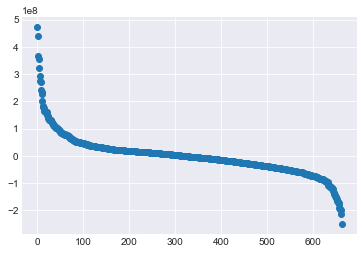

In [499]:
plt.scatter(range(len(df_sort)), df_sort.resid);

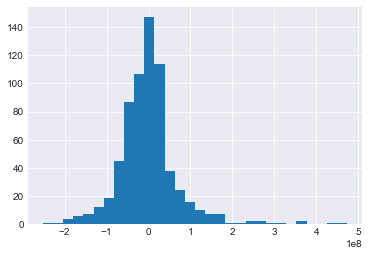

In [500]:
plt.hist(df_sort.resid, bins=30);

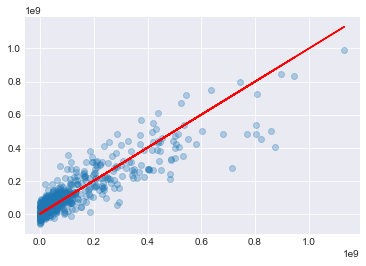

In [501]:
plt.scatter(y, fit.predict(X), alpha=0.3)
plt.plot(y, y, color='red');

# Separate Out Countries

In [543]:
countries_df = pd.read_pickle('cleaned_movies_w_country.pkl')

In [506]:
countries_df.shape

(28044, 15)

In [530]:
def strip_newline(s):
    return s.strip('\n')

In [531]:
countries_df['country'] = countries_df['country'].apply(strip_newline)

In [544]:
countries_df.head()

,budget,country,country_gross,days_out,distributor,domestic_gross,foreign_gross,genre,num_theaters,opening_weekend,rating,release_date,run_time,title,month
0,20000000.0,Austria,79788.0,42.0,Independent,14326864,17877166.0,Action-Adventure,2335,6231836.0,PG-13,2012-04-13,110.0,Lockout,April
1,20000000.0,Belgium,259122.0,42.0,Independent,14326864,17877166.0,Action-Adventure,2335,6231836.0,PG-13,2012-04-13,110.0,Lockout,April
2,20000000.0,Croatia,12377.0,42.0,Independent,14326864,17877166.0,Action-Adventure,2335,6231836.0,PG-13,2012-04-13,110.0,Lockout,April
3,20000000.0,Czech Republic,37787.0,42.0,Independent,14326864,17877166.0,Action-Adventure,2335,6231836.0,PG-13,2012-04-13,110.0,Lockout,April
4,20000000.0,Denmark,20642.0,42.0,Independent,14326864,17877166.0,Action-Adventure,2335,6231836.0,PG-13,2012-04-13,110.0,Lockout,April


In [533]:
countries_df.country.unique()

array(['Austria', 'Belgium', 'Croatia', 'Czech Republic', 'Denmark',
       'East Africa', 'France', 'Germany', 'Hong Kong', 'Iceland', 'Japan',
       'Lebanon', 'Malaysia', 'Netherlands', 'Philippines', 'Portugal',
       'Russia - CIS', 'Serbia & Montenegro', 'Singapore', 'Slovakia',
       'South Africa', 'South Korea', 'Spain', 'Thailand', 'Turkey',
       'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Australia',
       'Brazil', 'Bulgaria', 'Mexico', 'New Zealand', 'Argentina',
       'Bolivia', 'Chile', 'China', 'Colombia', 'Ecuador', 'Egypt',
       'Finland', 'Hungary', 'Nigeria', 'Norway', 'Peru', 'Poland',
       'Sweden', 'Uruguay', 'Venezuela', 'Italy', 'Israel', 'Slovenia',
       'Greece', 'Indonesia', 'Bahrain', 'Ghana', 'India', 'Estonia',
       'Lithuania', 'Taiwan', 'Latvia', 'Romania', 'Switzerland', 'Aruba',
       'Curacao', 'Dominican Republic', 'Ethiopia', 'Vietnam', 'Kuwait',
       'Oman', 'Qatar', 'Jamaica', 'Trinidad & Tobago',
       'Switzerland (

In [553]:
countries = countries_df.groupby(by=['country'])[['country_gross']].count()
countries.sort_values(by = ['country_gross'], ascending=False, inplace=True)
countries = countries[countries.country_gross >= 400]
countrylist = list(countries.index)
countrylist

['United Kingdom',
 'South Africa',
 'Germany',
 'Spain',
 'Mexico',
 'Australia',
 'Portugal',
 'United Arab Emirates',
 'Singapore',
 'France',
 'Brazil',
 'Russia - CIS',
 'Italy',
 'Netherlands',
 'Belgium',
 'Peru',
 'New Zealand',
 'Lebanon',
 'Austria',
 'Argentina',
 'Uruguay',
 'Iceland',
 'Turkey',
 'Poland',
 'Hong Kong',
 'Thailand',
 'Colombia',
 'Czech Republic',
 'Philippines',
 'Norway',
 'Croatia',
 'Bolivia',
 'Hungary',
 'Ukraine',
 'Greece',
 'Slovakia',
 'Venezuela',
 'Chile',
 'Finland',
 'Sweden',
 'Bulgaria',
 'Slovenia',
 'Malaysia',
 'Ecuador',
 'South Korea',
 'Denmark',
 'Serbia & Montenegro']

In [540]:
'Denmark' in countrylist

True

In [548]:
new_countries_df = countries_df[countries_df['country'].isin(countrylist)]

In [549]:
new_countries_df.country.value_counts()

United Kingdom          632
South Africa            604
Germany                 589
Spain                   583
Mexico                  582
Australia               571
Portugal                564
United Arab Emirates    562
France                  556
Singapore               556
Brazil                  551
Russia - CIS            549
Italy                   545
Netherlands             540
Belgium                 536
Peru                    530
New Zealand             527
Lebanon                 523
Austria                 522
Argentina               521
Uruguay                 515
Iceland                 514
Turkey                  500
Poland                  499
Hong Kong               494
Thailand                485
Colombia                480
Czech Republic          479
Philippines             478
Norway                  472
Croatia                 468
Bolivia                 465
Hungary                 457
Ukraine                 457
Greece                  456
Venezuela           

In [556]:
new_countries_df = add_dummy_vars(new_countries_df)

In [557]:
new_countries_df.head(1)

,budget,country,country_gross,days_out,distributor,domestic_gross,foreign_gross,genre,num_theaters,opening_weekend,...,month[T.February],month[T.January],month[T.July],month[T.June],month[T.March],month[T.May],month[T.November],month[T.October],month[T.September],month[T.April]
0,20000000.0,Austria,79788.0,42.0,Independent,14326864,17877166.0,Action-Adventure,2335,6231836.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [558]:
new_countries_df.to_pickle('top_countries.pkl')

In [559]:
new_countries_df = pd.read_pickle('top_countries.pkl')

In [562]:
def country_coeffs(df, countrylist):
    country_data = defaultdict()
    for country in countrylist:
        tempdf = df[df.country == country]
        X = tempdf[['budget', 'opening_weekend', 
       'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.April]']]
        y = tempdf['country_gross']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        est = LinearRegression()
        fit = est.fit(X_train, y_train)
        r2 = fit.score(X_test, y_test)
        country_data[country] = [r2, list(zip(X.columns, fit.coef_))]
    return country_data

In [563]:
country_data = country_coeffs(new_countries_df, countrylist)

In [564]:
country_data

defaultdict(None,
            {'Argentina': [0.31285531942997358,
              [('budget', 0.0034485575027677602),
               ('opening_weekend', 0.054406341326216801),
               ('genre[T.Comedy]', -790048.74509656546),
               ('genre[T.Documentary]', -419129.92089798534),
               ('genre[T.Drama]', -241536.89656972038),
               ('genre[T.Family]', 2767544.572185176),
               ('genre[T.Horror]', 209849.10134303465),
               ('genre[T.Other]', -925430.90868811216),
               ('genre[T.Thriller]', -110628.69626344257),
               ('genre[T.Action_Adventure]', -490618.50601238653),
               ('rating[T.PG]', 562801.19654370006),
               ('rating[T.PG-13]', -139402.76615769119),
               ('rating[T.R]', -43837.576850275625),
               ('rating[T.G]', -379560.85353573464),
               ('month[T.August]', -571971.58308024169),
               ('month[T.December]', -387662.59094756027),
               ('month[T.F

In [444]:
arg = countries_df[countries_df.country == 'Argentina']
arg.head()

,budget,country,country_gross,days_out,distributor,domestic_gross,foreign_gross,genre,num_theaters,opening_weekend,rating,release_date,run_time,title,month
50,50000000.0,Argentina,74517.0,42.0,Lionsgate,13414714,22211811.0,Action-Adventure,2557,6278491.0,R,2012-09-21,95.0,Dredd,September
93,6000000.0,Argentina,220915.0,28.0,Independent,11494838,1736623.0,Drama,2801,4750894.0,PG-13,2012-09-07,96.0,The Words,September
155,35000000.0,Argentina,232497.0,70.0,Universal,67544505,20514281.0,Comedy,2931,11579175.0,R,2012-12-21,133.0,This Is 40,December
231,30000000.0,Argentina,599848.0,96.0,Sony,66486205,110020614.0,Action-Adventure,2993,20801552.0,R,2012-09-28,118.0,Looper,September
282,17000000.0,Argentina,15422.0,140.0,Universal,65001093,50349333.0,Comedy,2787,14846830.0,PG-13,2012-09-28,112.0,Pitch Perfect,September


In [445]:
X = arg[['budget']]
y = arg['country_gross']
argmodel = sm.OLS(y,X)
argfit = argmodel.fit()
argfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          country_gross   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     462.8
Date:                Wed, 04 Oct 2017   Prob (F-statistic):           6.69e-74
Time:                        20:06:29   Log-Likelihood:                -8473.7
No. Observations:                 521   AIC:                         1.695e+04
Df Residuals:                     520   BIC:                         1.695e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
budget         0.0301      0.001     21.513      0.000       0.027       0.033
==============================================================================
Omnibus:                      628.499   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69456.005
Skew:                           5.684   Prob(JB):                         0.00
Kurtosis:                      58.410   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [446]:
arg = add_dummy_vars(arg)

In [447]:
arg.columns

Index(['budget', 'country', 'country_gross', 'days_out', 'distributor',
       'domestic_gross', 'foreign_gross', 'genre', 'num_theaters',
       'opening_weekend', 'rating', 'release_date', 'run_time', 'title',
       'month', 'genre[T.Comedy]', 'genre[T.Documentary]', 'genre[T.Drama]',
       'genre[T.Family]', 'genre[T.Horror]', 'genre[T.Other]',
       'genre[T.Thriller]', 'genre[T.Action_Adventure]', 'rating[T.PG]',
       'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]', 'distributor[T.Fox]',
       'distributor[T.Independent]', 'distributor[T.Lionsgate]',
       'distributor[T.Paramount]', 'distributor[T.Sony]',
       'distributor[T.Universal]', 'distributor[T.Warner Bros]',
       'distributor[T.Weinstein]', 'distributor[T.Disney]', 'month[T.August]',
       'month[T.December]', 'month[T.February]', 'month[T.January]',
       'month[T.July]', 'month[T.June]', 'month[T.March]', 'month[T.May]',
       'month[T.November]', 'month[T.October]', 'month[T.September]',
       'month[T.

In [448]:
X = arg[['budget', 'genre[T.Comedy]',
       'genre[T.Drama]', 'genre[T.Family]', 'genre[T.Horror]',
       'genre[T.Other]', 'genre[T.Thriller]', 'genre[T.Action_Adventure]',
       'rating[T.PG]', 'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]',
       'distributor[T.Fox]', 'distributor[T.Independent]',
       'distributor[T.Lionsgate]', 'distributor[T.Paramount]',
       'distributor[T.Sony]', 'distributor[T.Universal]',
       'distributor[T.Warner Bros]', 'distributor[T.Weinstein]',
       'distributor[T.Disney]', 'month[T.August]', 'month[T.December]',
       'month[T.February]', 'month[T.January]', 'month[T.July]',
       'month[T.June]', 'month[T.March]', 'month[T.May]', 'month[T.November]',
       'month[T.October]', 'month[T.September]', 'month[T.April]']]
y = arg['country_gross']
argmodel = sm.OLS(y,X)
argfit = argmodel.fit()
argfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          country_gross   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     11.58
Date:                Wed, 04 Oct 2017   Prob (F-statistic):           2.31e-40
Time:                        20:06:37   Log-Likelihood:                -8419.9
No. Observations:                 521   AIC:                         1.690e+04
Df Residuals:                     490   BIC:                         1.703e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
budget                         0.0266      0.003      9.020      0.000       0.021       0.032
genre[T.Comedy]             1.116e+06   2.25e+06      0.496      0.620   -3.31e+06    5.54e+06
genre[T.Drama]              1.481e+06   2.25e+06      0.658      0.511   -2.94e+06    5.91e+06
genre[T.Family]             3.735e+06   2.17e+06      1.721      0.086   -5.29e+05       8e+06
genre[T.Horror]             2.803e+06   2.28e+06      1.228      0.220   -1.68e+06    7.29e+06
genre[T.Other]              1.384e+06   2.41e+06      0.574      0.567   -3.36e+06    6.12e+06
genre[T.Thriller]           1.569e+06   2.29e+06      0.686      0.493   -2.93e+06    6.06e+06
genre[T.Action_Adventure]   1.221e+06   2.26e+06      0.541      0.589   -3.21e+06    5.65e+06
rating[T.PG]               -5.536e+05   1.31e+06     -0.423      0.672   -3.12e+06    2.02e+06
rating[T.PG-13]            -1.019e+06   1.36e+06     -0.748      0.455    -3.7e+06    1.66e+06
rating[T.R]                -9.095e+05   1.36e+06     -0.668      0.504   -3.58e+06    1.76e+06
rating[T.G]                -4.195e+05   1.14e+06     -0.368      0.713   -2.66e+06    1.82e+06
distributor[T.Fox]         -1.582e+05    6.3e+05     -0.251      0.802    -1.4e+06    1.08e+06
distributor[T.Independent] -3.326e+05   6.26e+05     -0.531      0.595   -1.56e+06    8.97e+05
distributor[T.Lionsgate]   -4.645e+05   6.39e+05     -0.727      0.467   -1.72e+06     7.9e+05
distributor[T.Paramount]   -1.181e+05   6.01e+05     -0.197      0.844    -1.3e+06    1.06e+06
distributor[T.Sony]        -8.072e+05   6.02e+05     -1.342      0.180   -1.99e+06    3.75e+05
distributor[T.Universal]   -1.194e+05   6.07e+05     -0.197      0.844   -1.31e+06    1.07e+06
distributor[T.Warner Bros] -4.541e+05   5.98e+05     -0.760      0.448   -1.63e+06     7.2e+05
distributor[T.Weinstein]   -4.348e+05   7.46e+05     -0.583      0.560    -1.9e+06    1.03e+06
distributor[T.Disney]      -1.255e+04   6.35e+05     -0.020      0.984   -1.26e+06    1.24e+06
month[T.August]            -8.635e+05   5.37e+05     -1.608      0.108   -1.92e+06    1.91e+05
month[T.December]          -7.708e+05   5.42e+05     -1.423      0.155   -1.84e+06    2.93e+05
month[T.February]          -5.898e+05   5.34e+05     -1.105      0.270   -1.64e+06    4.59e+05
month[T.January]           -3.698e+05   6.03e+05     -0.614      0.540   -1.55e+06    8.14e+05
month[T.July]               1.161e+06   5.33e+05      2.179      0.030    1.14e+05    2.21e+06
month[T.June]               2.818e+05   5.79e+05      0.487      0.627   -8.56e+05    1.42e+06
month[T.March]             -9.738e+05   5.58e+05     -1.745      0.082   -2.07e+06    1.23e+05
month[T.May]                6.635e+05   5.75e+05      1.153      0.249   -4.67e+05    1.79e+06
month[T.November]          -3.544e+05   5.4

In [288]:
ger = countries_df[countries_df.country == 'Germany']
ger = add_dummy_vars(ger)
X = ger[['budget', 'genre[T.Comedy]',
       'genre[T.Drama]', 'genre[T.Family]', 'genre[T.Horror]',
       'genre[T.Other]', 'genre[T.Thriller]', 'genre[T.Action_Adventure]',
       'rating[T.PG]', 'rating[T.PG-13]', 'rating[T.R]', 'rating[T.G]',
       'distributor[T.Fox]', 'distributor[T.Independent]',
       'distributor[T.Lionsgate]', 'distributor[T.Paramount]',
       'distributor[T.Sony]', 'distributor[T.Universal]',
       'distributor[T.Warner Bros]', 'distributor[T.Weinstein]',
       'distributor[T.Disney]', 'month[T.August]', 'month[T.December]',
       'month[T.February]', 'month[T.January]', 'month[T.July]',
       'month[T.June]', 'month[T.March]', 'month[T.May]', 'month[T.November]',
       'month[T.October]', 'month[T.September]', 'month[T.April]']]
y = ger['country_gross']
X = sm.add_constant(X, prepend=True)
germodel = sm.OLS(y,X)
gerfit = germodel.fit()
gerfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          country_gross   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     8.935
Date:                Wed, 04 Oct 2017   Prob (F-statistic):           1.11e-29
Time:                        13:34:06   Log-Likelihood:                -7905.6
No. Observations:                 453   AIC:                         1.587e+04
Df Residuals:                     422   BIC:                         1.600e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -1.176e+06   6.87e+06     -0.171      0.864   -1.47e+07    1.23e+07
budget                         0.1230      0.012     10.326      0.000       0.100       0.146
genre[T.Comedy]            -6.626e+05   9.98e+06     -0.066      0.947   -2.03e+07     1.9e+07
genre[T.Drama]             -5.665e+05   9.99e+06     -0.057      0.955   -2.02e+07    1.91e+07
genre[T.Family]             3.507e+06   9.88e+06      0.355      0.723   -1.59e+07    2.29e+07
genre[T.Horror]             1.664e+06   1.01e+07      0.165      0.869   -1.82e+07    2.15e+07
genre[T.Other]             -2.435e+06   1.05e+07     -0.233      0.816    -2.3e+07    1.81e+07
genre[T.Thriller]          -1.524e+06   1.01e+07     -0.150      0.881   -2.14e+07    1.84e+07
genre[T.Action_Adventure]  -1.302e+06   1.01e+07     -0.130      0.897   -2.11e+07    1.85e+07
rating[T.PG]               -5.133e+05   2.36e+06     -0.218      0.828   -5.15e+06    4.12e+06
rating[T.PG-13]             7.562e+05   2.57e+06      0.294      0.769    -4.3e+06    5.82e+06
rating[T.R]                 2.937e+06   2.61e+06      1.127      0.260   -2.18e+06    8.06e+06
rating[T.G]                -4.356e+06    5.9e+06     -0.739      0.460   -1.59e+07    7.23e+06
distributor[T.Fox]          5.422e+05   1.43e+06      0.380      0.704   -2.26e+06    3.35e+06
distributor[T.Independent] -7.646e+05    1.7e+06     -0.450      0.653    -4.1e+06    2.58e+06
distributor[T.Lionsgate]    8.346e+05   1.69e+06      0.494      0.621   -2.48e+06    4.15e+06
distributor[T.Paramount]   -1.324e+06   1.48e+06     -0.892      0.373   -4.24e+06    1.59e+06
distributor[T.Sony]          6.82e+05   1.39e+06      0.491      0.624   -2.05e+06    3.41e+06
distributor[T.Universal]    2.182e+05   1.44e+06      0.152      0.880   -2.61e+06    3.05e+06
distributor[T.Warner Bros] -2.511e+06   1.38e+06     -1.817      0.070   -5.23e+06    2.05e+05
distributor[T.Weinstein]    1.757e+06   2.62e+06      0.670      0.503    -3.4e+06    6.91e+06
distributor[T.Disney]      -6.106e+05    1.8e+06     -0.339      0.734   -4.15e+06    2.92e+06
month[T.August]            -1.756e+06   1.58e+06     -1.115      0.266   -4.85e+06    1.34e+06
month[T.December]           1.885e+06   1.54e+06      1.221      0.223   -1.15e+06    4.92e+06
month[T.February]          -2.341e+05   1.66e+06     -0.141      0.888   -3.51e+06    3.04e+06
month[T.January]           -1.225e+06   1.78e+06     -0.687      0.493   -4.73e+06    2.28e+06
month[T.July]                1.58e+06   1.46e+06      1.081      0.280   -1.29e+06    4.45e+06
month[T.June]              -3.051e+04   1.71e+06     -0.018      0.986   -3.39e+06    3.33e+06
month[T.March]               -3.1e+06   1.65e+06     -1.878      0.061   -6.35e+06    1.45e+05
month[T.May]               -1.422e+06   1.8